In [561]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Getting the data

In [562]:
# download the names.txt file from github

import requests

url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"

In [563]:
response = requests.get(url)

if response.status_code == 200:
    with open("names.txt", "w") as file:
        file.write(response.text)
    print("Le fichier a été téléchargé avec succès.")
else:
    print("Le téléchargement du fichier a échoué")

Le fichier a été téléchargé avec succès.


In [564]:
# response.text.splitlines() allows us to directly get the list but in the case I'm working offline, I download locally the file

In [565]:
#with open("names.txt", "r") as file:
#    raw_names = file.read()

raw_names = open('names.txt', 'r').read()

In [566]:
names = raw_names.splitlines()
print(len(names))
names[:5]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia']

# Building the vocabulary of characters and mapping it

In [567]:
characters = sorted(list(set(''.join(name for name in names))))
char_to_int = {char:i+1 for i, char in enumerate(characters)}
char_to_int["."] = 0 #special character to begin of put an end to a sequence
int_to_char = {i:char for char, i in char_to_int.items()}

# Building the dataset

In [568]:
context_size = 3 # number of precedents char to take into account

def build_dataset(words, context_size):
    X = []
    y = []

    for name in names:
        context = [0] * context_size

        for char in name + '.':
            idx = char_to_int[char]
            X.append(context)
            y.append(idx)

            #print(f"{''.join(int_to_char[i] for i in context)}")

            context = context[1:] + [idx]

    X, y = torch.tensor(X), torch.tensor(y)
    print(f"X.shape : {X.shape}, y.shape : {y.shape}")

    return X, y

In [569]:
X, y = build_dataset(names, context_size)

X.shape : torch.Size([228146, 3]), y.shape : torch.Size([228146])


In [570]:
import random
random.seed(42)
random

n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])

Xtr, Xval, Xtst = X.tensor_split((n1, n2), dim=0)
ytr, yval, ytst = y.tensor_split((n1, n2), dim=0)

In [571]:
print(f"Xtr.shape : {Xtr.shape}, Xval.shape : {Xval.shape}, Xtst.shape : {Xtst.shape}")

Xtr.shape : torch.Size([182516, 3]), Xval.shape : torch.Size([22815, 3]), Xtst.shape : torch.Size([22815, 3])


# Designing the MLP

In [572]:
g = torch.Generator().manual_seed(42) # for reproductibility

In [573]:
C = torch.rand([27, 3], generator=g) # characters to vectors
W1 = torch.rand([3*3, 100], generator=g) # putting in the MLP 4 characters and each one of them has 2 dimensionnal vector associated
b1 = torch.rand(100, generator=g)
W2 = torch.rand([100, 27], generator=g)
b2 = torch.rand(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True # we need to give this information to torch

In [574]:
# number of parameters in total

sum(p.nelement() for p in parameters)

3808

# Train the model

In [575]:
loss_i, loss_val = [], []
iterations = 200000

In [576]:
def training_and_valid(Xtrain, ytrain, Xvalid, yvalid, iterations, batch_size):

    for i in range(iterations):
        if i % 50000 == 0:
            print(i)
        # batch construction
        batch_idx = torch.randint(0, Xtr.shape[0], (batch_size,))

        # forward pass
        emb = C[Xtrain[batch_idx]]
        h = F.tanh(emb.view(-1, 9) @ W1 + b1)
        logits = h @ W2 + b2

        loss = F.cross_entropy(logits, ytrain[batch_idx])

        # backward pass
        for p in parameters:
            p.grad = None # reset the gradient to avoid accumulation
        loss.backward()

        # update
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += - lr * p.grad
        
        loss_i.append(loss.item()) # to avoid the weird effect on the loss curve

        # validation set
        #if i % 150: # saving time
        #    emb = C[Xvalid]
        #    h = F.tanh(emb.view(-1, 8) @ W1 + b1)
        #    logits = h @ W2 + b2
        #    loss_val.append(F.cross_entropy(logits, yvalid).item())
        #else:
        #    loss_val.append(loss_val[-1])
        #print(loss.item())
    return loss_i, loss_val

In [577]:
train_loss, val_loss = training_and_valid(Xtrain=Xtr, ytrain=ytr, Xvalid=Xval, yvalid=yval, iterations=iterations, batch_size=32)

0


50000
100000
150000


2.1984791579711436


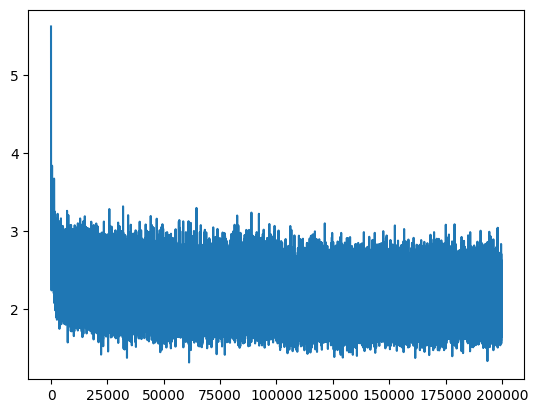

In [578]:
x = torch.arange(0, len(train_loss))

print((sum(train_loss)/len(train_loss)))
plt.plot(x, train_loss)
#plt.plot(x, val_loss)

plt.show()

In [579]:
# val_loss

emb = C[Xval]
h = F.tanh(emb.view(-1, 9) @ W1 + b1)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, yval).item()
val_loss

2.404094696044922

# Vizualising character embedding

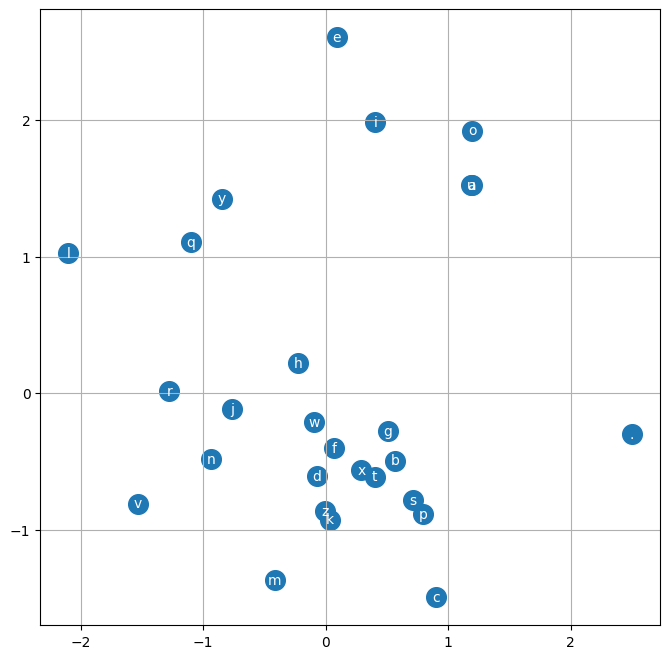

In [582]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), int_to_char[i], ha="center", va="center", color='white')

plt.grid(True)

plt.show()

# Trying to make more names !

In [581]:
# sample from the model
g = torch.Generator().manual_seed(42)

for _ in range(20):

    out = []
    context = [0] * context_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(int_to_char[i] for i in out))

yansy.
haviah.
nolle.
kha.
mariya.
tryah.
arhen.
emberlynn.
ize.
abkeles.
lon.
tophalita.
mariolannezise.
shallamie.
ela.
lun.
kaylyn.
zerianne.
neh.
daumole.
